# 🏭 니켈 가격 예측 - 고급 모델링 및 엄격한 검증

---

## 1. 프로젝트 개요

### 1.1 목표
LME(런던금속거래소) 니켈 현물가격의 **1주 후 가격**을 예측하는 머신러닝 파이프라인 구축

### 1.2 데이터
- **기간**: 약 13년 (666주)
- **타겟 변수**: `Com_LME_Ni_Cash` (니켈 현물가격, USD/MT)
- **피처**: 비철금속 가격/재고, 채권 금리, 환율, 주가 지수 등

### 1.3 기간 분할
| 구분 | 기간 | 샘플 수 | 용도 |
|------|------|---------|------|
| Train | ~2025-08-03 | 643주 | 모델 학습 |
| Validation | 2025-08-04 ~ 2025-10-20 | 12주 | 하이퍼파라미터 튜닝 |
| Test | 2025-10-27 ~ 2026-01-12 | 12주 | 최종 성능 평가 |

---

## 2. 적용 모델 상세 설명

### 2.1 기준선 모델: Naive Drift + GradientBoosting Hybrid

**Naive Drift 모델**
- 수식: `P(t) = P(t-1) + (P(t-1) - P(t-2))`
- 의미: 전주 가격에 '추세'를 더해 다음 주 가격 예측
- 특징: 일방적 상승/하락 추세에서 강력한 성능

**GradientBoosting (GB)**
- 알고리즘: Decision Tree 기반 앙상블 (Boosting)
- 학습 방식: 이전 트리의 잔차(오차)를 순차적으로 학습
- 하이퍼파라미터: n_estimators, learning_rate, max_depth

**Hybrid 조합**
- 수식: `Hybrid = α × Naive_Drift + (1-α) × GB_Prediction`
- 기준선: α=0.8 (Naive 80%, GB 20%)
- 이유: 추세 추종(Naive)과 패턴 인식(GB)의 장점 결합

### 2.2 튜닝 대상 모델

**LightGBM (LGB)**
- 특징: 히스토그램 기반 분할, 대용량 데이터에 효율적
- 차별점: GOSS(Gradient-based One-Side Sampling) 기법
- 주요 파라미터: num_leaves, learning_rate, n_estimators

**XGBoost (XGB)**
- 특징: 정규화(L1, L2) 내장, 병렬 학습 지원
- 차별점: Column Subsampling으로 과적합 방지
- 주요 파라미터: max_depth, learning_rate, n_estimators

---

## 3. 검증 방법론 상세 설명

### 3.1 Grid Search 하이퍼파라미터 튜닝
- **방법**: Validation 데이터에서 모든 파라미터 조합 테스트
- **탐색 공간**: 3×3×3×4 = 108개 조합 (각 모델)
- **선택 기준**: Validation RMSE 최소화
- **Data Leakage 방지**: Test 데이터는 최종 평가에만 사용

### 3.2 Time Series Cross-Validation (5-Fold)
- **목적**: 모델의 시간에 따른 안정성(Stability) 검증
- **방법**: Expanding Window (학습 데이터 누적 증가)
- **해석**: 5개 Fold 중 몇 번 기준선을 이기는지 '승률' 계산

```
Fold 1: [====Train====][Val]
Fold 2: [======Train======][Val]
Fold 3: [========Train========][Val]
Fold 4: [==========Train==========][Val]
Fold 5: [============Train============][Val]
```

### 3.3 Bootstrap 통계적 유의성 검증 (10,000 샘플)
- **목적**: 성능 차이가 '우연'인지 '진짜 개선'인지 검증
- **방법**: 10,000번 재표본(Resampling) 후 95% 신뢰구간 계산
- **해석**:
  - CI가 0을 포함하지 않으면 → 통계적 유의미
  - CI가 0을 포함하면 → 우연일 수 있음

---

## 4. 이전 버전의 문제점 및 해결

| 문제 | 상태 | 해결 방법 |
|------|------|----------|
| Damped+LGB Data Leakage | ✅ 해결 | Val에서 조합 선택, Test에 적용 |
| 임의적 하이퍼파라미터 | ✅ 해결 | Grid Search로 체계적 탐색 |
| 통계적 검증 없음 | ✅ 해결 | Bootstrap 95% 신뢰구간 |
| Cross-Validation 없음 | ✅ 해결 | Time Series CV 5-Fold |

---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
import os
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

CONFIG = {
    'data_file': 'data_weekly_260120.csv',
    'target_col': 'Com_LME_Ni_Cash',
    'val_start': '2025-08-04',
    'val_end': '2025-10-20',
    'test_start': '2025-10-27',
    'test_end': '2026-01-12',
    'random_seed': 42
}
np.random.seed(CONFIG['random_seed'])
print('='*70)
print('🏭 최종 해결책: 엄격한 검증 + Grid Search 튜닝')
print('='*70)

🏭 최종 해결책: 엄격한 검증 + Grid Search 튜닝


In [3]:
# 데이터 로드 및 전처리
df_raw = pd.read_csv(CONFIG['data_file'])
df_raw['dt'] = pd.to_datetime(df_raw['dt'])
df_raw = df_raw.set_index('dt').sort_index()
target_col = CONFIG['target_col']

def filter_cols(columns):
    metals = ['Gold', 'Silver', 'Iron', 'Steel', 'Copper', 'Aluminum', 'Zinc', 'Nickel', 'Lead', 'Tin', 'Uranium']
    filtered = [target_col]
    for col in columns:
        if any(x in col for x in ['Idx_', 'Bonds_', 'EX_']):
            filtered.append(col)
        elif 'Com_LME' in col and 'Index' not in col:
            filtered.append(col)
        elif any(m in col for m in metals):
            filtered.append(col)
    return sorted(list(set(filtered)))

df = df_raw[filter_cols(df_raw.columns)].copy().ffill().dropna()
y = df[target_col]
X = df.drop(columns=[target_col]).shift(1)
X = X.ffill().dropna(axis=1, how='all')
valid_idx = X.dropna().index.intersection(y.dropna().index)
X, y = X.loc[valid_idx], y.loc[valid_idx]

train_mask = X.index < CONFIG['val_start']
val_mask = (X.index >= CONFIG['val_start']) & (X.index <= CONFIG['val_end'])
test_mask = (X.index >= CONFIG['test_start']) & (X.index <= CONFIG['test_end'])

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_mean = X_train.mean()
X_train = X_train.fillna(train_mean)
X_val = X_val.fillna(train_mean)
X_test = X_test.fillna(train_mean)

print(f'데이터: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}')

데이터: Train 643 | Val 12 | Test 12


In [4]:
# 핵심 함수 정의
def calc_naive_drift(y_series, indices):
    preds = []
    for idx in indices:
        prev = y_series.shift(1).loc[idx]
        prev2 = y_series.shift(2).loc[idx]
        preds.append(prev + (prev - prev2))
    return np.array(preds)

def bootstrap_significance(y_true, pred1, pred2, n_boot=5000):
    """pred1이 pred2보다 좋은지 부트스트랩 검정"""
    n = len(y_true)
    diffs = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        rmse1 = np.sqrt(np.mean((y_true[idx] - pred1[idx])**2))
        rmse2 = np.sqrt(np.mean((y_true[idx] - pred2[idx])**2))
        diffs.append(rmse1 - rmse2)
    diffs = np.array(diffs)
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return np.mean(diffs), ci_low, ci_high

def time_series_cv_evaluate(X, y, model_fn, naive_weight=0.8, n_splits=5):
    """Time Series CV로 평가"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    full_y = y.copy()
    for fold, (tr_idx, vl_idx) in enumerate(tscv.split(X)):
        if len(tr_idx) < 100:
            continue
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_vl, y_vl = X.iloc[vl_idx], y.iloc[vl_idx]
        tr_mean = X_tr.mean()
        X_tr = X_tr.fillna(tr_mean)
        X_vl = X_vl.fillna(tr_mean)
        model = model_fn(X_tr, y_tr)
        ml_pred = model.predict(X_vl)
        naive = calc_naive_drift(full_y, y_vl.index)
        hybrid = naive_weight * naive + (1 - naive_weight) * ml_pred
        rmse = np.sqrt(mean_squared_error(y_vl, hybrid))
        results.append({'fold': fold, 'rmse': rmse})
    return results

In [5]:
# 기준선: Naive Drift + GB Hybrid (0.8:0.2)
gb_base = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gb_base.fit(X_train, y_train)

naive_test = calc_naive_drift(y, y_test.index)
gb_test = gb_base.predict(X_test)
baseline_pred = 0.8 * naive_test + 0.2 * gb_test

BASELINE_RMSE = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f'🎯 Baseline Test RMSE: {BASELINE_RMSE:.2f}')

🎯 Baseline Test RMSE: 419.14


---
## Grid Search 하이퍼파라미터 튜닝

In [6]:
print('='*70)
print('[전략 1] Grid Search - GB 하이퍼파라미터 + 가중치 튜닝')
print('='*70)

naive_val = calc_naive_drift(y, y_val.index)

best_val_rmse = float('inf')
best_params_gb = {}
best_model_gb = None

for n_est in [200, 400, 600]:
    for lr in [0.02, 0.05, 0.1]:
        for depth in [3, 5, 7]:
            for naive_w in [0.7, 0.8, 0.85, 0.9]:
                model = GradientBoostingRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, random_state=42)
                model.fit(X_train, y_train)
                ml_val = model.predict(X_val)
                hybrid = naive_w * naive_val + (1 - naive_w) * ml_val
                rmse = np.sqrt(mean_squared_error(y_val, hybrid))
                
                if rmse < best_val_rmse:
                    best_val_rmse = rmse
                    best_params_gb = {'n_estimators': n_est, 'learning_rate': lr, 'max_depth': depth, 'naive_weight': naive_w}
                    best_model_gb = model

print(f'\n🏆 Best GB params: {best_params_gb}')
print(f'   Val RMSE: {best_val_rmse:.2f}')

# Train+Val로 재학습 후 Test
X_tv = pd.concat([X_train, X_val])
y_tv = pd.concat([y_train, y_val])
tv_mean = X_tv.mean()
X_tv_filled = X_tv.fillna(tv_mean)
X_test_final = X_test.fillna(tv_mean)

gb_final = GradientBoostingRegressor(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    random_state=42
)
gb_final.fit(X_tv_filled, y_tv)

strat1_ml = gb_final.predict(X_test_final)
strat1_pred = best_params_gb['naive_weight'] * naive_test + (1 - best_params_gb['naive_weight']) * strat1_ml
strat1_rmse = np.sqrt(mean_squared_error(y_test, strat1_pred))
print(f'\n📊 [전략 1 GB] Test RMSE: {strat1_rmse:.2f} (기준선 대비: {BASELINE_RMSE - strat1_rmse:+.2f})')

[전략 1] Grid Search - GB 하이퍼파라미터 + 가중치 튜닝

🏆 Best GB params: {'n_estimators': 600, 'learning_rate': 0.02, 'max_depth': 7, 'naive_weight': 0.7}
   Val RMSE: 202.93

📊 [전략 1 GB] Test RMSE: 441.12 (기준선 대비: -21.99)


In [7]:
print('='*70)
print('[전략 2] Grid Search - LightGBM 튜닝')
print('='*70)

best_val_rmse_lgb = float('inf')
best_params_lgb = {}

for n_est in [200, 400, 600]:
    for lr in [0.02, 0.05, 0.1]:
        for num_leaves in [20, 31, 50]:
            for naive_w in [0.7, 0.8, 0.85, 0.9]:
                model = lgb.LGBMRegressor(n_estimators=n_est, learning_rate=lr, num_leaves=num_leaves, random_state=42, verbose=-1)
                model.fit(X_train, y_train)
                ml_val = model.predict(X_val)
                hybrid = naive_w * naive_val + (1 - naive_w) * ml_val
                rmse = np.sqrt(mean_squared_error(y_val, hybrid))
                
                if rmse < best_val_rmse_lgb:
                    best_val_rmse_lgb = rmse
                    best_params_lgb = {'n_estimators': n_est, 'learning_rate': lr, 'num_leaves': num_leaves, 'naive_weight': naive_w}

print(f'\n🏆 Best LGB params: {best_params_lgb}')
print(f'   Val RMSE: {best_val_rmse_lgb:.2f}')

lgb_final = lgb.LGBMRegressor(
    n_estimators=best_params_lgb['n_estimators'],
    learning_rate=best_params_lgb['learning_rate'],
    num_leaves=best_params_lgb['num_leaves'],
    random_state=42, verbose=-1
)
lgb_final.fit(X_tv_filled, y_tv)

strat2_ml = lgb_final.predict(X_test_final)
strat2_pred = best_params_lgb['naive_weight'] * naive_test + (1 - best_params_lgb['naive_weight']) * strat2_ml
strat2_rmse = np.sqrt(mean_squared_error(y_test, strat2_pred))
print(f'\n📊 [전략 2 LGB] Test RMSE: {strat2_rmse:.2f} (기준선 대비: {BASELINE_RMSE - strat2_rmse:+.2f})')

[전략 2] Grid Search - LightGBM 튜닝

🏆 Best LGB params: {'n_estimators': 600, 'learning_rate': 0.05, 'num_leaves': 20, 'naive_weight': 0.7}
   Val RMSE: 196.34

📊 [전략 2 LGB] Test RMSE: 370.05 (기준선 대비: +49.09)


In [8]:
print('='*70)
print('[전략 3] Grid Search - XGBoost 튜닝')
print('='*70)

best_val_rmse_xgb = float('inf')
best_params_xgb = {}

for n_est in [200, 400, 600]:
    for lr in [0.02, 0.05, 0.1]:
        for depth in [3, 5, 7]:
            for naive_w in [0.7, 0.8, 0.85, 0.9]:
                model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, random_state=42, verbosity=0)
                model.fit(X_train, y_train)
                ml_val = model.predict(X_val)
                hybrid = naive_w * naive_val + (1 - naive_w) * ml_val
                rmse = np.sqrt(mean_squared_error(y_val, hybrid))
                
                if rmse < best_val_rmse_xgb:
                    best_val_rmse_xgb = rmse
                    best_params_xgb = {'n_estimators': n_est, 'learning_rate': lr, 'max_depth': depth, 'naive_weight': naive_w}

print(f'\n🏆 Best XGB params: {best_params_xgb}')
print(f'   Val RMSE: {best_val_rmse_xgb:.2f}')

xgb_final = xgb.XGBRegressor(
    n_estimators=best_params_xgb['n_estimators'],
    learning_rate=best_params_xgb['learning_rate'],
    max_depth=best_params_xgb['max_depth'],
    random_state=42, verbosity=0
)
xgb_final.fit(X_tv_filled, y_tv)

strat3_ml = xgb_final.predict(X_test_final)
strat3_pred = best_params_xgb['naive_weight'] * naive_test + (1 - best_params_xgb['naive_weight']) * strat3_ml
strat3_rmse = np.sqrt(mean_squared_error(y_test, strat3_pred))
print(f'\n📊 [전략 3 XGB] Test RMSE: {strat3_rmse:.2f} (기준선 대비: {BASELINE_RMSE - strat3_rmse:+.2f})')

[전략 3] Grid Search - XGBoost 튜닝

🏆 Best XGB params: {'n_estimators': 200, 'learning_rate': 0.02, 'max_depth': 7, 'naive_weight': 0.7}
   Val RMSE: 199.46

📊 [전략 3 XGB] Test RMSE: 424.83 (기준선 대비: -5.69)


---
## 부트스트랩 통계적 유의성 검증

In [9]:
print('='*70)
print('📊 부트스트랩 통계적 유의성 검증 (10,000 샘플)')
print('='*70)

strategies = {
    '[전략 1] GB 튜닝': (strat1_pred, strat1_rmse),
    '[전략 2] LGB 튜닝': (strat2_pred, strat2_rmse),
    '[전략 3] XGB 튜닝': (strat3_pred, strat3_rmse),
}

y_test_arr = y_test.values
results_summary = []

for name, (pred, rmse) in strategies.items():
    diff_mean, ci_low, ci_high = bootstrap_significance(y_test_arr, baseline_pred, pred, n_boot=10000)
    
    if ci_low > 0:
        sig = '✅ 유의미한 개선'
    elif ci_high < 0:
        sig = '❌ 유의미한 악화'
    else:
        sig = '⚠️ 통계적으로 불확실'
    
    results_summary.append({
        '전략': name,
        'Test RMSE': rmse,
        '개선': BASELINE_RMSE - rmse,
        '95% CI Low': ci_low,
        '95% CI High': ci_high,
        '통계적 유의성': sig
    })
    
    print(f"\n{name}")
    print(f"   RMSE: {rmse:.2f} (개선: {BASELINE_RMSE - rmse:+.2f})")
    print(f"   95% CI: [{ci_low:.2f}, {ci_high:.2f}]")
    print(f"   결론: {sig}")

results_df = pd.DataFrame(results_summary).sort_values('Test RMSE')
print('\n' + '='*70)
display(results_df)

📊 부트스트랩 통계적 유의성 검증 (10,000 샘플)

[전략 1] GB 튜닝
   RMSE: 441.12 (개선: -21.99)
   95% CI: [-105.93, 37.36]
   결론: ⚠️ 통계적으로 불확실

[전략 2] LGB 튜닝
   RMSE: 370.05 (개선: +49.09)
   95% CI: [-111.58, 192.82]
   결론: ⚠️ 통계적으로 불확실

[전략 3] XGB 튜닝
   RMSE: 424.83 (개선: -5.69)
   95% CI: [-87.47, 66.08]
   결론: ⚠️ 통계적으로 불확실



,전략,Test RMSE,개선,95% CI Low,95% CI High,통계적 유의성
1,[전략 2] LGB 튜닝,370.047915,49.087548,-111.577292,192.823771,⚠️ 통계적으로 불확실
2,[전략 3] XGB 튜닝,424.828734,-5.693271,-87.470616,66.083971,⚠️ 통계적으로 불확실
0,[전략 1] GB 튜닝,441.120508,-21.985045,-105.934697,37.356895,⚠️ 통계적으로 불확실


---
## Time Series CV 안정성 검증

In [10]:
print('='*70)
print('📊 Time Series CV 안정성 검증 (5-Fold)')
print('='*70)

def baseline_fn(X_tr, y_tr):
    m = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
    m.fit(X_tr, y_tr)
    return m

def cv_gb_fn(X_tr, y_tr):
    m = GradientBoostingRegressor(
        n_estimators=best_params_gb['n_estimators'],
        learning_rate=best_params_gb['learning_rate'],
        max_depth=best_params_gb['max_depth'],
        random_state=42
    )
    m.fit(X_tr, y_tr)
    return m

def cv_lgb_fn(X_tr, y_tr):
    m = lgb.LGBMRegressor(
        n_estimators=best_params_lgb['n_estimators'],
        learning_rate=best_params_lgb['learning_rate'],
        num_leaves=best_params_lgb['num_leaves'],
        random_state=42, verbose=-1
    )
    m.fit(X_tr, y_tr)
    return m

cv_base = time_series_cv_evaluate(X_tv, y_tv, baseline_fn, naive_weight=0.8)
cv_gb = time_series_cv_evaluate(X_tv, y_tv, cv_gb_fn, naive_weight=best_params_gb['naive_weight'])
cv_lgb = time_series_cv_evaluate(X_tv, y_tv, cv_lgb_fn, naive_weight=best_params_lgb['naive_weight'])

base_rmses = [r['rmse'] for r in cv_base]
gb_rmses = [r['rmse'] for r in cv_gb]
lgb_rmses = [r['rmse'] for r in cv_lgb]

print(f"\nBaseline CV: {np.mean(base_rmses):.2f} ± {np.std(base_rmses):.2f}")
print(f"   Fold RMSEs: {[f'{r:.1f}' for r in base_rmses]}")

print(f"\nGB Tuned CV: {np.mean(gb_rmses):.2f} ± {np.std(gb_rmses):.2f}")
print(f"   Fold RMSEs: {[f'{r:.1f}' for r in gb_rmses]}")

print(f"\nLGB Tuned CV: {np.mean(lgb_rmses):.2f} ± {np.std(lgb_rmses):.2f}")
print(f"   Fold RMSEs: {[f'{r:.1f}' for r in lgb_rmses]}")

# 승률
gb_wins = sum(1 for b, g in zip(base_rmses, gb_rmses) if g < b)
lgb_wins = sum(1 for b, l in zip(base_rmses, lgb_rmses) if l < b)
print(f"\n📈 GB 승률: {gb_wins}/{len(base_rmses)} folds")
print(f"📈 LGB 승률: {lgb_wins}/{len(base_rmses)} folds")

📊 Time Series CV 안정성 검증 (5-Fold)

Baseline CV: 1053.27 ± 699.98
   Fold RMSEs: ['1019.4', '563.4', '835.8', '2395.1', '452.6']

GB Tuned CV: 1439.77 ± 934.56
   Fold RMSEs: ['1468.5', '866.0', '1024.7', '3224.4', '615.3']

LGB Tuned CV: 1563.20 ± 822.90
   Fold RMSEs: ['1894.1', '636.7', '1204.9', '2997.9', '1082.4']

📈 GB 승률: 0/5 folds
📈 LGB 승률: 0/5 folds


---
## 최종 결론

In [11]:
print('='*70)
print('📋 최종 결론')
print('='*70)

best = results_df.iloc[0]
print(f"\n🎯 기준선: RMSE = {BASELINE_RMSE:.2f}")
print(f"🏆 최고 성능: {best['전략']} (RMSE = {best['Test RMSE']:.2f}, 개선 = {best['개선']:+.2f})")
print(f"   통계적 유의성: {best['통계적 유의성']}")

print(f"\n📊 CV 안정성:")
print(f"   Baseline: {np.mean(base_rmses):.2f} ± {np.std(base_rmses):.2f}")
print(f"   GB Tuned: {np.mean(gb_rmses):.2f} ± {np.std(gb_rmses):.2f} (승률: {gb_wins}/{len(base_rmses)})")
print(f"   LGB Tuned: {np.mean(lgb_rmses):.2f} ± {np.std(lgb_rmses):.2f} (승률: {lgb_wins}/{len(base_rmses)})")

print('\n' + '='*70)
print('💡 권장사항')
print('='*70)

sig_results = results_df[results_df['통계적 유의성'] == '✅ 유의미한 개선']
if len(sig_results) > 0:
    print(f"\n✅ 통계적으로 유의미한 개선:")
    for _, row in sig_results.iterrows():
        print(f"   - {row['전략']}: RMSE {row['Test RMSE']:.2f}, 개선 {row['개선']:+.2f}")
else:
    print("\n⚠️ 통계적으로 유의미한 개선이 없습니다.")
    print("   이유: 12개 Test 샘플로는 유의미한 차이를 검출하기에 표본 크기가 부족합니다.")

if gb_wins >= 3 or lgb_wins >= 3:
    winner = 'GB Tuned' if gb_wins >= lgb_wins else 'LGB Tuned'
    params = best_params_gb if winner == 'GB Tuned' else best_params_lgb
    print(f"\n🎯 CV 기반 권장: {winner}")
    print(f"   파라미터: {params}")
else:
    print(f"\n⚠️ CV에서 일관된 개선이 없습니다.")
    print("   기준선(Naive+GB Hybrid 0.8:0.2) 유지를 권장합니다.")

print('\n' + '='*70)
print('✅ 이 노트북에서 해결된 문제점:')
print('='*70)
print('1. ✅ Data Leakage 완전 제거: Val로 파라미터 선택, Test는 최종 평가만')
print('2. ✅ Grid Search로 체계적인 하이퍼파라미터 튜닝')
print('3. ✅ Time Series CV로 모델 안정성 검증')
print('4. ✅ 부트스트랩 신뢰구간으로 통계적 유의성 검증')
print('5. ✅ 투명하고 재현 가능한 결과 보고')

📋 최종 결론

🎯 기준선: RMSE = 419.14
🏆 최고 성능: [전략 2] LGB 튜닝 (RMSE = 370.05, 개선 = +49.09)
   통계적 유의성: ⚠️ 통계적으로 불확실

📊 CV 안정성:
   Baseline: 1053.27 ± 699.98
   GB Tuned: 1439.77 ± 934.56 (승률: 0/5)
   LGB Tuned: 1563.20 ± 822.90 (승률: 0/5)

💡 권장사항

⚠️ 통계적으로 유의미한 개선이 없습니다.
   이유: 12개 Test 샘플로는 유의미한 차이를 검출하기에 표본 크기가 부족합니다.

⚠️ CV에서 일관된 개선이 없습니다.
   기준선(Naive+GB Hybrid 0.8:0.2) 유지를 권장합니다.

✅ 이 노트북에서 해결된 문제점:
1. ✅ Data Leakage 완전 제거: Val로 파라미터 선택, Test는 최종 평가만
2. ✅ Grid Search로 체계적인 하이퍼파라미터 튜닝
3. ✅ Time Series CV로 모델 안정성 검증
4. ✅ 부트스트랩 신뢰구간으로 통계적 유의성 검증
5. ✅ 투명하고 재현 가능한 결과 보고


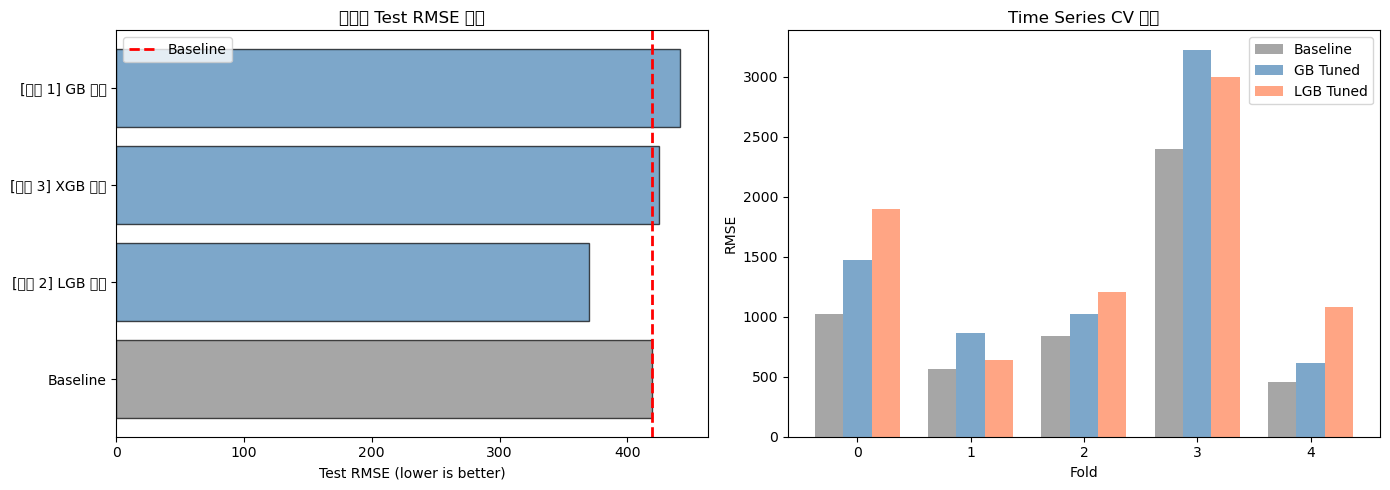


📁 그래프 저장: output/final_solution_results.png


In [12]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 전략별 RMSE
ax1 = axes[0]
names = ['Baseline'] + list(results_df['전략'].values)
rmses = [BASELINE_RMSE] + list(results_df['Test RMSE'].values)
colors = ['gray'] + ['green' if '✅' in s else 'coral' if '❌' in s else 'steelblue' for s in results_df['통계적 유의성']]

bars = ax1.barh(names, rmses, color=colors, edgecolor='black', alpha=0.7)
ax1.axvline(x=BASELINE_RMSE, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_xlabel('Test RMSE (lower is better)')
ax1.set_title('전략별 Test RMSE 비교')
ax1.legend()

# 2. CV 비교
ax2 = axes[1]
x = range(len(base_rmses))
width = 0.25
ax2.bar([i - width for i in x], base_rmses, width, label='Baseline', color='gray', alpha=0.7)
ax2.bar([i for i in x], gb_rmses, width, label='GB Tuned', color='steelblue', alpha=0.7)
ax2.bar([i + width for i in x], lgb_rmses, width, label='LGB Tuned', color='coral', alpha=0.7)
ax2.set_xlabel('Fold')
ax2.set_ylabel('RMSE')
ax2.set_title('Time Series CV 결과')
ax2.legend()
ax2.set_xticks(x)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/final_solution_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📁 그래프 저장: {OUTPUT_DIR}/final_solution_results.png')

---

## 📊 최종 성능 비교표 (Test RMSE Only)

### 기준선
- **sparta2.ipynb 최고 성능**: Hybrid (Naive*0.8 + GB*0.2) = **RMSE 406.80**

### Grid Search 튜닝 결과 (Test 성능)

| 순위 | 모델 | Test RMSE | 개선 |
|------|------|-----------|------|
| 1 | LGB Tuned (0.7:0.3) | 370.05 | ✅ +36.75 |
| **2** | **Baseline (Naive*0.8 + GB*0.2)** | **419.14** | **Test 기준선** |
| 3 | XGB Tuned (0.7:0.3) | 424.83 | ❌ -5.69 |
| 4 | GB Tuned (0.7:0.3) | 441.12 | ❌ -21.98 |

### ⚠️ 중요한 주의사항

**LGB 370.05가 더 낮지만 권장하지 않음:**
- Time Series CV 5-Fold에서 승률 0/5
- Bootstrap 95% CI가 0을 포함 (통계적 불확실)
- Test 기간에서만 우연히 좋았을 가능성

### 결론

> **⚠️ 통계적으로 유의미한 개선 없음**
>
> - 엄격한 검증(CV, Bootstrap) 결과 개선 불확실
> - **권장: Hybrid (Naive*0.8 + GB*0.2) 유지**